# Notebook Overview
Same code as Final_code2.ipynb but with :
- MOCA behavioural tests and Fugi_Meyer test for motor
or
- MOCA_total test for behavioural tests and Fugi_Meyer test for motor
Thus in these cases, NMF is not needed.

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
simple_model = True

In [3]:
# Read and concatenate the data
datas = pd.concat([pd.read_excel(f'../Data/TiMeS_matrix_mdImputed_allT{i}.xlsx').assign(Timepoint=i, time=i-1) for i in range(1, 5)], ignore_index=True)

display(datas.head())

#print(np.array(datas.columns))

,Patient,Fugl.Meyer_affected_UPPER_EXTREMITY,Fugl.Meyer_affected_WRIST,Fugl.Meyer_affected_HAND,Fugl.Meyer_affected_COORDINATION.SPEED,Fugl.Meyer_affected_TOTAL,P.G_affected_FIST_mean,P.G_affected_PINCH_mean,P.G_affected_KEY_mean,MRC_affected,...,Doors_total,X2min,X10m_confortable_speed,X10m_max_speed,TUG,X5pts_correct_productions,X5pts_perseverative_productions,X5pts_perseverations_.,X5pts_strategic_productions,X5pts_strategic_.
0,P001,30.0,10.0,14.0,4.0,58.0,45.333333,6.666667,6.833333,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P002,30.0,10.0,13.0,4.0,57.0,15.000000,2.333333,3.666667,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P003,30.0,10.0,14.0,6.0,60.0,34.000000,5.666667,8.000000,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P004,18.0,10.0,14.0,6.0,47.0,17.666667,3.500000,3.166667,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P005,30.0,10.0,14.0,5.0,59.0,36.333333,4.033333,5.566667,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define the list of tests for each domains

In [4]:
# Normalisation function for paired and single data
def norm(X, affected_list, unaffected_list, paired_norm):
    """
    This function normalizes the data based on the formula from the paper https://www.biorxiv.org/content/10.1101/2022.05.23.493043v1.abstract
    The function takes in the data, the list of affected and unaffected column names and paired_norm, the new list of column names for the normalized data
    Returns a dataframe with the normalized data and the column names
    """

    # create an empty dataframe
    norm_df = pd.DataFrame()

    # Normalize paired motor data based on formula from paper https://www.biorxiv.org/content/10.1101/2022.05.23.493043v1.abstract 
    # Pair motor data refers to the test for which the data was acquired both for the affected and unaffected side
    # if the all lists exist, the data is normalized
    if affected_list and unaffected_list and paired_norm:
        
            for af,unaf,col_name in zip(affected_list, unaffected_list, paired_norm):

                norm_df[col_name] = (X[unaf] - X[af])/(X[af] + X[unaf])

                if col_name == "Ashworth_norm" or col_name == "X9HPT_norm":

                    norm_df[col_name] = - norm_df[col_name]

                # NOTE: Mildly negative values are unlikely: we set negative values to 0
                norm_df[col_name] = norm_df[col_name].apply(lambda x: 0 if x < 0 else x)

    # check if negative values exist
    if (norm_df < 0).any().any():
        print('Negative values exist')

    # get the column names
    column_names = list(norm_df.columns)

    return norm_df, column_names

In [5]:
def motor_transform(df):
    ''' Normalizes the motor data and returns a dataframe with the normalized data and the column names''' 

    motor_affected =   ["Fugl.Meyer_affected_TOTAL"]

    motor_unaffected = ["Fugl.Meyer_unaffected_TOTAL"]
    
    motor_paired_norm =["Fugl.Meyer_norm"]

    info = df[["Patient","Timepoint"]]

    norm_df, column_names = norm(df, affected_list = motor_affected, unaffected_list = motor_unaffected, paired_norm = motor_paired_norm)

    # add the patient and timepoint columns
    norm_df = pd.concat([info, norm_df], axis = 1)

    return norm_df, column_names

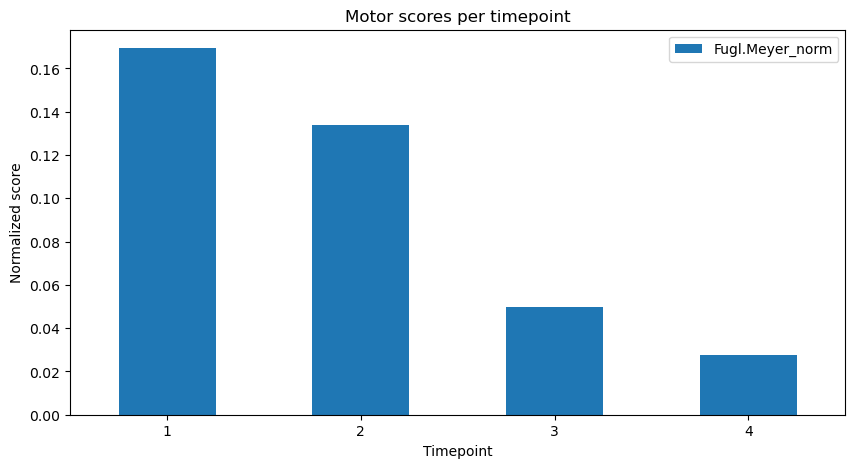

In [6]:
motor_df, columns = motor_transform(datas)

# plot the mean of motor columns per timepoint to check if the normalization worked
# Indeed the mean decreases over time, patients get better
motor_df.drop("Patient", axis=1).groupby('Timepoint').mean().plot.bar(figsize=(10,5), rot=0)
plt.title('Motor scores per timepoint')
plt.xlabel('Timepoint')
plt.ylabel('Normalized score')
plt.legend()
plt.show()

### General min-max normalization

In [7]:
if simple_model:
    cognitive_col = ['MOCA_Total_corrected']
else:
    cognitive_col = ['MOCA_attention_tot', 'MOCA_language_tot', 'MOCA_visuo.spatial.executive', 'MOCA_memory', 'MOCA_denomination', 'MOCA_abstraction', 'MOCA_orientation']

# get the cognitive data
norm_data = datas[cognitive_col]

# add '_norm' to the column names
norm_data.columns = norm_data.columns + '_norm'
norm_data_domains = list(norm_data.columns)

# add patient and timepoint columns to norm_data
norm_data['Patient'] = datas['Patient']
norm_data['Timepoint'] = datas['Timepoint']

# add motor df to norm_data
norm_data = pd.merge(motor_df, norm_data, on=['Patient', 'Timepoint'])

display(motor_df)
norm_data

,Patient,Timepoint,Fugl.Meyer_norm
0,P001,1,0.008547
1,P002,1,0.008696
2,P003,1,0.000000
3,P004,1,0.000000
4,P005,1,0.008403
...,...,...,...
231,P076,4,0.000000
232,P077,4,0.030303
233,P079,4,0.035714
234,P081,4,0.000000


,Patient,Timepoint,Fugl.Meyer_norm,MOCA_Total_corrected_norm
0,P001,1,0.008547,24
1,P002,1,0.008696,23
2,P003,1,0.000000,21
3,P004,1,0.000000,25
4,P005,1,0.008403,22
...,...,...,...,...
231,P076,4,0.000000,25
232,P077,4,0.030303,22
233,P079,4,0.035714,21
234,P081,4,0.000000,30


,Timepoint,Fugl.Meyer_norm,MOCA_Total_corrected_norm
count,236.000000,236.000000,236.000000
mean,2.296610,0.105799,0.772599
std,1.109413,0.251976,0.177974
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.666667
50%,2.000000,0.008696,0.814815
75%,3.000000,0.043671,0.888889
max,4.000000,1.000000,1.000000


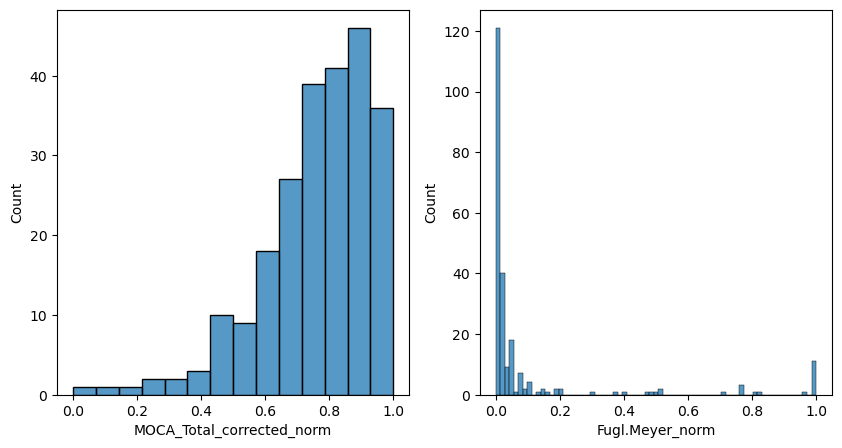

In [8]:
# Apply min-max normalization of norm_data for each column except on patient and timepoint
#print(norm_data.columns )
columns = norm_data_domains + ["Fugl.Meyer_norm"]
norm_data[columns] = norm_data[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

display(norm_data.describe())

if simple_model:
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    for i, col in enumerate(columns):
        sns.histplot(norm_data[col], ax=ax[i])
else :
    fig, ax = plt.subplots(4, 2, figsize=(20,20))
    for i, col in enumerate(columns):
        sns.histplot(norm_data[col], ax=ax[i//2, i%2])




### Making sure all tests are interpreted in the same way: the higher the score, the more impaired the patient is

In [9]:
# Iterate over each cognitive domain
for domain in norm_data_domains:
    norm_data[domain] = 1 - norm_data[domain]


# Clustering

In [10]:
# List of the domains we want to use for the clustering
col_list_clustering = columns

# Convert the data to list
data_list = [norm_data[norm_data["Timepoint"]==i].drop(["Timepoint"],axis=1) for i in norm_data["Timepoint"].unique()]


#################################################### Timepoint 1 ########################################################
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')
(74, 2)
       MOCA_Total_corrected_norm  Fugl.Meyer_norm
count                  74.000000        74.000000
mean                    0.278716         0.169401
std                     0.216443         0.311880
min                     0.000000         0.000000
25%                     0.125000         0.008403
50%                     0.250000         0.031003
75%                     0.364583         0.092172
max                     1.000000         1.000000
 
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')


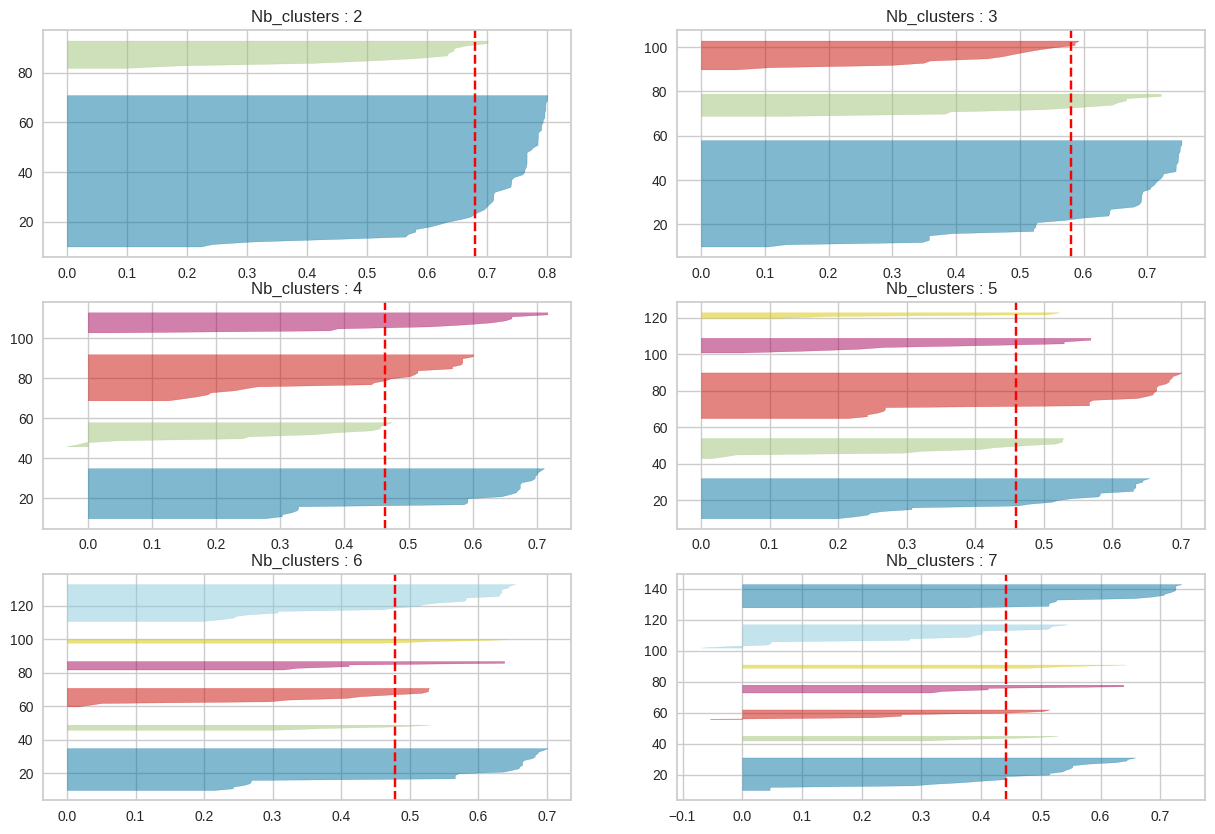

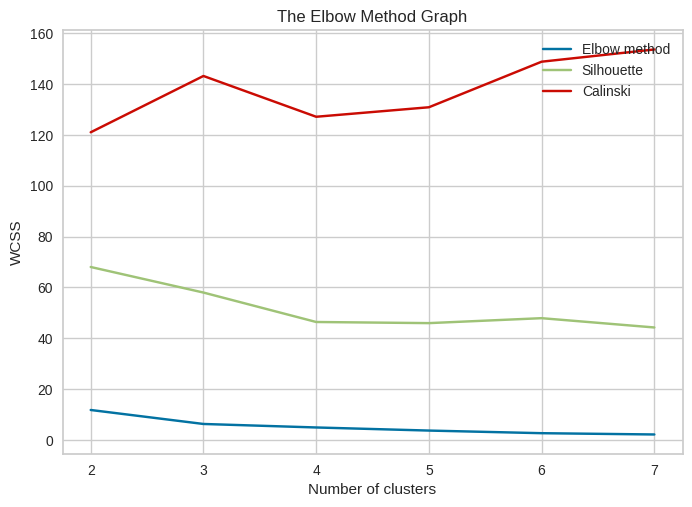

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score

# min max normalization of the NMF features before clustering
scaler = MinMaxScaler()

distances = []

timepoint = 0

print('#################################################### Timepoint',str(timepoint+1),'########################################################')

# uncomment to normalise
X = data_list[timepoint][col_list_clustering]

col = X.columns
print(col)

# fit on timepoint 1, transform on the others
X = scaler.fit_transform(X)
    
# convert the array to a dataframe
X = pd.DataFrame(X)
X.columns = col


print(X.shape)
print(X.describe())
print(' ')
print(X.columns)

nb_clusters = 8

# Create an empty list
wcss=[]
sil = []
calinski = []

fig, ax = plt.subplots(3, 2, figsize=(15,10))

# Loop to fill the WCSS list for each nb of clusters
for i in range(2,nb_clusters):
    kmeans_test = KMeans(init='random', n_clusters=i, n_init=10,
                max_iter=300, random_state=42)
    kmeans_test.fit(X)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(kmeans_test, colors='yellowbrick', ax=ax[q-1][mod], init = 'k_means++')
    visualizer.fit(X)
    ax[q-1, mod].title.set_text("Nb_clusters : "+ str(i))

    wcss.append(kmeans_test.inertia_*3)
    sil.append(silhouette_score(X,kmeans_test.labels_)/0.01)
    calinski.append(calinski_harabasz_score(X, kmeans_test.labels_))


# plot silhouette graphs
plt.show()
fig.tight_layout()

range_ = range(2,nb_clusters)

# Plot the resume of WCSS values comparing to nb of clusters
plt.plot(range_,wcss, label = 'Elbow method')
plt.legend(loc='upper center')
plt.plot(range_,sil, label = 'Silhouette')
plt.legend(loc='upper center')
plt.plot(range_,calinski, label = 'Calinski')
plt.legend(loc='upper right')
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# save the plot
plt.show()

Based on the best number of clusters found above, we can now apply the KMeans algorithm to T1, and then classify patients from the other timepoints based on the centroids of the clusters found at T1:

In [12]:
from sklearn.cluster import KMeans
n_clusters = 2

# min max normalization of the NMF features before clustering
scaler = MinMaxScaler()

probabilities = []

for timepoint in range(0,4):

    print('####################################################',str(timepoint+1),'########################################################')

    X = data_list[timepoint][col_list_clustering]
     
    # uncomment to normalise
    col = X.columns

    # fit on timepoint 1, transform on the others
    if timepoint == 0:
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
        
    # convert the array to a dataframe
    X = pd.DataFrame(X)
    X.columns = col

    print(X.shape)
    # measure the mean and std of NMF_df
    display(X.describe())
    print(' ')
    print(X.columns)
    

    # keep clusters of timepoint 1 only 
    if timepoint == 0:

        kmeans = KMeans(n_clusters=n_clusters,init ='k-means++', max_iter=100, n_init=10,random_state=42).fit(X)
        centers = kmeans.cluster_centers_

    #get labels
    labels = kmeans.predict(X)

    # Initialize list to hold information about each cluster in order to later sort the clusters
    cluster_info = []
    labels_name = np.unique(labels)

    for i in labels_name:
        # Identifying indices of points belonging to the current cluster
        cluster_points_indices = np.where(labels == i)[0]
        # Selecting the actual points belonging to the current cluster
        cluster_points = X.iloc[cluster_points_indices]

        # Adding information about the current cluster to the list
        cluster_info.append({
            'cluster_index': i,
            'cluster_points': cluster_points, 
            'cluster_indices_in_data': cluster_points_indices.tolist()
        })

    # Sorting the clusters based on the number of points they contain
    sorted_cluster_info = sorted(cluster_info, key=lambda x: len(x['cluster_points']), reverse=True)

    #map label to ordered labels
    ordered_labels = {sorted_cluster_info[i]['cluster_index'] : i for i in range(len(sorted_cluster_info))}

    # measure distances between each patient and the centroids of timepoint 1
    dist = np.zeros((X.shape[0], n_clusters))
    for k in range(n_clusters):
        dist[:, k] = np.linalg.norm(X - centers[k], axis=1)
    
    # compute the probability of each patient to belong to each cluster
    sum_distances = np.sum(dist, axis=1)
    proba = (1 - dist / sum_distances[:, None])/(n_clusters-1)

    # store the probabilities
    probabilities.append(proba)
    
    # transform labels list into list with ordered labels
    ordered_labels_list = [ordered_labels[label] for label in labels]
    # measure labels based on the clusters of timepoint 1
    data_list[timepoint]['Labels'] = ordered_labels_list

#################################################### 1 ########################################################
(74, 2)


,MOCA_Total_corrected_norm,Fugl.Meyer_norm
count,74.000000,74.000000
mean,0.278716,0.169401
std,0.216443,0.311880
min,0.000000,0.000000
25%,0.125000,0.008403
50%,0.250000,0.031003
75%,0.364583,0.092172
max,1.000000,1.000000


 
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')
#################################################### 2 ########################################################
(64, 2)


,MOCA_Total_corrected_norm,Fugl.Meyer_norm
count,64.000000,64.000000
mean,0.243490,0.134011
std,0.220006,0.279238
min,-0.041667,0.000000
25%,0.083333,0.000000
50%,0.208333,0.016949
75%,0.343750,0.056964
max,1.083333,1.000000


 
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')
#################################################### 3 ########################################################
(52, 2)


,MOCA_Total_corrected_norm,Fugl.Meyer_norm
count,52.000000,52.000000
mean,0.151442,0.049702
std,0.155909,0.172077
min,-0.041667,0.000000
25%,0.041667,0.000000
50%,0.083333,0.008403
75%,0.218750,0.017317
max,0.583333,1.000000


 
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')
#################################################### 4 ########################################################
(46, 2)


,MOCA_Total_corrected_norm,Fugl.Meyer_norm
count,46.000000,46.000000
mean,0.140399,0.027643
std,0.140918,0.115718
min,-0.041667,0.000000
25%,0.041667,0.000000
50%,0.125000,0.000000
75%,0.208333,0.008403
max,0.583333,0.764706


 
Index(['MOCA_Total_corrected_norm', 'Fugl.Meyer_norm'], dtype='object')


In [13]:
# For ease of use, columns are renamed
if simple_model:
    for i in range(0,4):
        data_list[i].rename(columns = {'MOCA_Total_corrected_norm':'cognitive', 'Fugl.Meyer_norm':'motor'}, inplace = True)
else :
    for i in range(0,4):
        data_list[i].rename(columns = {'MOCA_attention_tot_norm':'attention', "MOCA_language_tot_norm":"language", 
                                    "MOCA_visuo.spatial.executive_norm": "visuo.spatial.executive", 
                                    "MOCA_memory_norm":"memory", "MOCA_denomination_norm":"denomination", 
                                    "MOCA_abstraction_norm":"abstraction", "MOCA_orientation_norm":"orientation", 
                                    "Fugl.Meyer_norm":"motor"}, inplace = True)

In [14]:
# save this dataframe
csv_path = "../Data/Lisa/"
file_name = "Without_NMF"

if simple_model:
    file_name = file_name + "_2features"
else:
    file_name = file_name + "_MOCA"

for i in range(4):
    data_list[i].to_csv(csv_path + file_name + "_" + str(i) + ".csv")